<a href="https://colab.research.google.com/github/HilbertN/Analisis_de_datos_Tareas/blob/main/Tarea3_Ajuste_de_parametros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [151]:
import numpy as np 
import pandas as pd 
import sympy as sp
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from pylab import *  # for plotting commands
import scipy.optimize as optimize
from scipy import optimize

In [152]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [153]:
#Ejercicio 1:Cargar los datos y Graficar
ola=pd.read_csv('/content/drive/My Drive/Base de datos/Puebla_pos.csv')

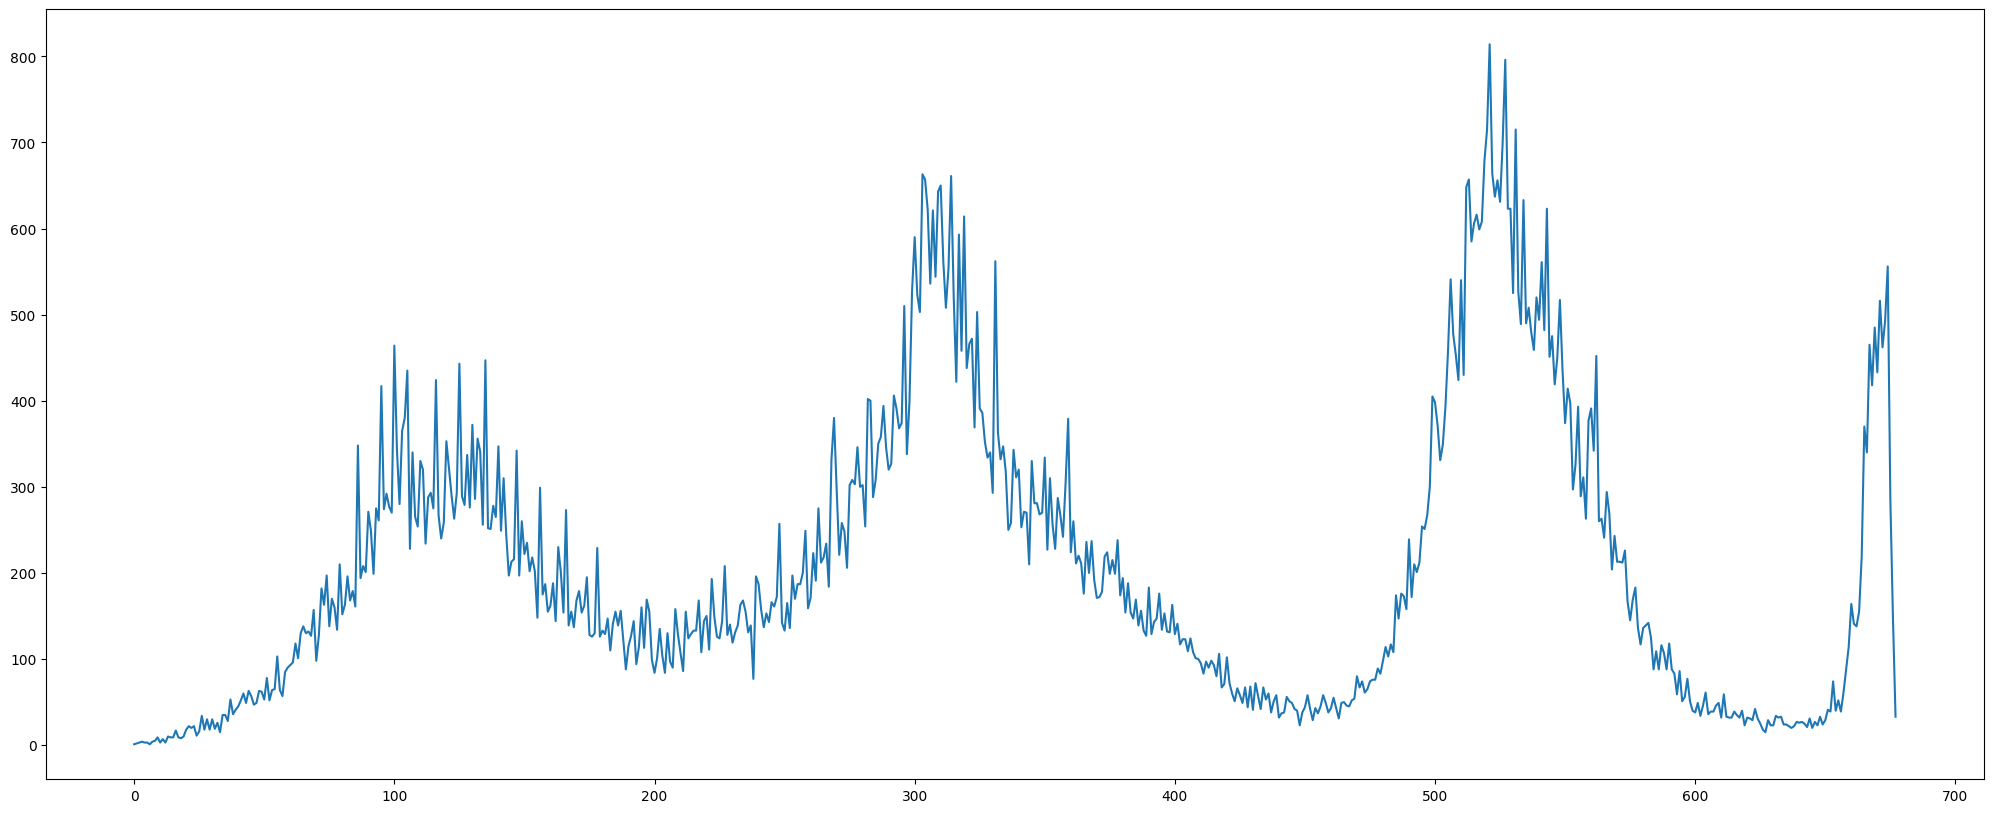

In [154]:
#Graficamos todos los datos
fig,ax=plt.subplots(figsize=(25,10))
ax.plot(ola['Unnamed: 0'],ola['positivo'])
plt.show()

In [155]:
#Casos acumulados por semana 
ola['FECHA_SINTOMAS'] = pd.to_datetime(ola['FECHA_SINTOMAS'])
ola.set_index('FECHA_SINTOMAS', inplace=True)
ola=ola.drop('Unnamed: 0',axis=1)


In [156]:
#Realizamos la suma de los casos acumulados por semana
ola=ola.resample('W').sum()
#Cambiamos la fecha de sintomas por el número de semana
ola.index=np.arange(1,99)
ola.index.name='Semana'
ola

,positivo
Semana,
1,6
2,20
3,50
4,104
5,149
...,...
94,216
95,468
96,1527


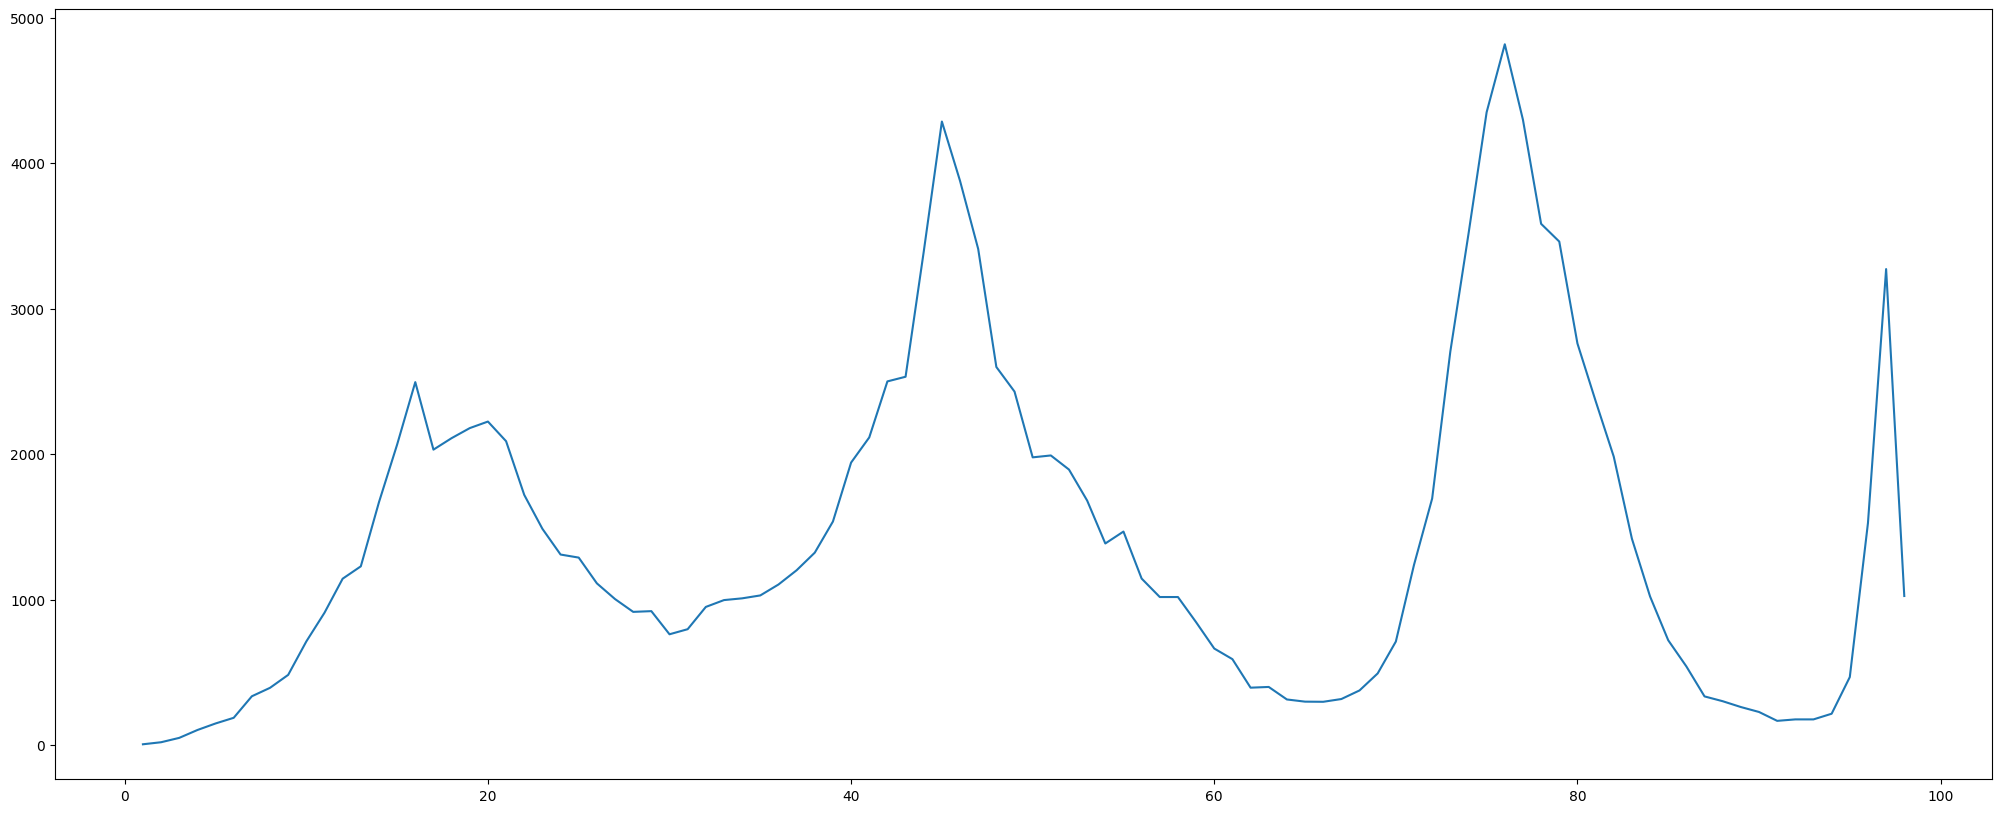

In [157]:
#Graficamos los datos 
ax,fig=plt.subplots(figsize=(25,10))
fig.plot(np.arange(1,99),ola['positivo'])
plt.show()

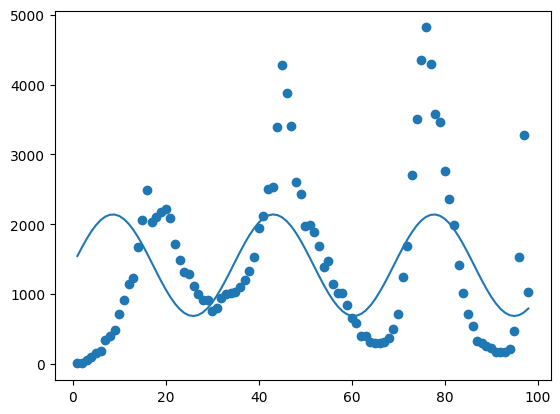

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 685.5044867751423
        x: [ 2.590e+01]
      nit: 5
      jac: [ 0.000e+00]
     nfev: 14
     njev: 7
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [166]:
#Ajustamos una seinodal a la base de los casos acumulados para encontrar una posible ola de la infección
#Se obtiene que la primera ola termina aproximadamente en la semana 27
def f(x,a,b,c): 
  return a*sin(b*x)+c 
alpha ,cov= optimize.curve_fit(f, xdata = np.arange(1,99), ydata = ola['positivo'])
plt.scatter(np.arange(1,99),ola['positivo'])

x=np.arange(1,99)
plt.plot(x,f(x,alpha[0],alpha[1],alpha[2]))
plt.show()

def g(x): 
  return alpha[0]*sin(alpha[1]*x)+alpha[2] 

min=optimize.minimize(g,np.array([6]),bounds=[(20,40)])
min

In [159]:
#Ejercicio 2: Ajustar la primera ola con m ́ınimos cuadrados

#Tomamos solo los valores del indice 0 al 34, esto sirve para lo que sigue del código
ola1.index=np.arange(0,35)
#Tomamos los datos de tipo flotante
ola1=ola1.astype(float)
#Cambiamos el nombre a los índices
ola1=ola.iloc[0:35]
def SIC(y,t,gamma,beta):
	S=y[0]
	I=y[1]
	C=y[2]
	N=S+I
	
	dS = -beta * S*I/N
	dI = beta * S*I/N - gamma*I
	dC = beta*S*I/N
	return np.array([dS,dI,dC])


def Acum(gamma,beta): 
  def model(y,t): 
    return SIC(y,t,gamma,beta)
  t=np.arange(0,35)
  N0=31000.0 
  y0=np.array([N0-1.,1.,0.])
  sol=odeint(model,y0,t) 
  return sol[:,2]

def cost(params): 
    predict=pd.DataFrame(Acum(params[0],params[1]),columns=['positivo'])
    costo=np.sum(np.power(predict['positivo']-ola1['positivo'],2.0))
    return costo

x0=np.array([0.01,5])
res=optimize.minimize(cost,x0,bounds=[(0,10),(0,10)])
res




  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 31332933.863348834
        x: [ 9.920e+00  1.000e+01]
      nit: 5
      jac: [ 3.302e+07  2.286e+07]
     nfev: 249
     njev: 83
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [160]:
#Intentamos usar curvefit, pero me marca error. Entonces le agregué un punto inicial
#t=np.arange(0,35)
#param, cov = optimize.curve_fit(Acum, t, ola1['positivo'],p0=(0.1,0.1))
#param
#No funcionó

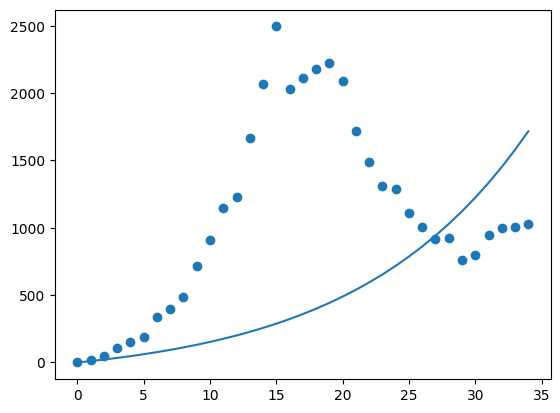

In [161]:
t=np.arange(0,35)
N0=31000.0 
y0=np.array([N0-1.,1.,0.])

def model(y,t):
	return SIC(y,t,res.x[0],res.x[1])
model_prediction = odeint(model, y0, t)

plt.plot(t,model_prediction[:,2])
plt.scatter(t,ola1['positivo'])
plt.show()

In [162]:
#Ejercicio 3:Ajustar la segunda ola con una cadena de Monte Carlo y dar intervalosde confianza para los parámetros
def PoissonLikelihood(dat, model_prediction):
	loglike=0.0
	for x, L in zip(dat, model_prediction):
		if(L>0.0):
			loglike = loglike - L + x*np.log(L)
	return loglike
		
def SIC(y,t,gamma,beta):
	S=y[0]
	I=y[1]
	C=y[2]
	N=6583278.0
	
	dS = -beta * S*I/N
	dI = beta * S*I/N - gamma*I
	dC = beta*S*I/N
	return np.array([dS,dI,dC])

In [163]:
#Tamaño de pasos
sigma_gamma = 0.0001;
sigma_beta = 0.0001
gamma = 0.333
beta = 0.499

like=0.0000000001
#Le ayuda a la computadora, para que no trabaje con números grandes
loglike=np.log(like)
Number_of_steeps = 10000
#Si mi punto inicial esta equivocado, entonces no toma esos 1000 pasos hasta que llegue al punto estacionario, ya que puede surgir sesgo
Burn_in_Time = 1000
#Archivo donde se van a guardar los valores
mcmc_file_name = "mcmc.dat"

In [164]:
file_h = open(mcmc_file_name,"w+",buffering=1)
file_h.write('gamma,beta,log_likelihood\n')
random=0
for i in range(Number_of_steeps):
	#verificar que sea positivo, porque estamos tratando con un modelo SIR
	gamma_try = np.random.normal(gamma, sigma_gamma)
	while (gamma_try < 0.0):
		gamma_try = np.random.normal(gamma, sigma_gamma)
	beta_try = np.random.normal(beta, sigma_beta)
	while (beta_try < 0.0):
		beta_try = np.random.normal(beta, sigma_beta)
		
	#definir el modelo con los parametros elegidos
	def model(y,t):
		return SIC(y,t,gamma_try,beta_try)
		
	#resolver el modelo
	N0=658378.0 
	y0 = np.array([N0-1.,1.,0.])
	model_prediction = odeint(model, y0, t)
	
	#calcular likelihood
	loglike_try = PoissonLikelihood(ola['positivo'],model_prediction[:,2])
	
	#calcular numero aleatorio para comparar con la division de la anterior
	if (loglike_try < loglike):
		random = np.random.uniform(0.0,1.0)
		accepted = np.exp(loglike_try - loglike)
	else:
		accepted = 1.
		
	if ( random < accepted):
		gamma = gamma_try
		beta = beta_try
		loglike = loglike_try

	if(i>Burn_in_Time):
		line = '{} , {} , {} \n'.format(gamma,beta,loglike)
		file_h.write(line)


file_h.close()

In [165]:
MCMC = pd.read_csv(mcmc_file_name)
MCMC.head()

,gamma,beta,log_likelihood
0,0.333,0.499,-23.025851
1,0.333,0.499,-23.025851
2,0.333,0.499,-23.025851
3,0.333,0.499,-23.025851
4,0.333,0.499,-23.025851
